# Testing the msl_mhm library within an oscillatory problem

Let's redo our simulations of a diffusion process with an oscillatory coefficient using the MHM method. And instead of only looking at the L2- and H1-norm errors, let's take a look at some colorful results!

**Mind that, for the code below to work smoothly, the directory `results_oscillatory` must exist in the root of this Jupyter notebook!**

In [ ]:
import os

path = "results_oscillatory_m"
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Now, we're ready to proceed to C++. As always, you first need to setup the location of the include and library files:

In [ ]:
#pragma cling add_library_path("/usr/local/lib/")

#pragma cling add_include_path("/usr/local/include")
#pragma cling add_include_path("/usr/local/include/msl_core")
#pragma cling add_include_path("/usr/local/include/msl_core/third_party")
#pragma cling add_include_path("/usr/local/include/msl_cg")
#pragma cling add_include_path("/usr/local/include/msl_mhm")

#pragma cling load("libeasyloggingpp.so")
#pragma cling load("libtriangle.so")
#pragma cling load("libtetgen.so")
#pragma cling load("libmsl_core.so")
#pragma cling load("libmsl_cg.so")
#pragma cling load("libmsl_mhm.so")

#pragma cling load("libomp.so")


After that, just `#include` the relevant header files...



In [ ]:
#include <memory>
#include <string>
#include <valarray>
#include <vector>
#include <fstream>
#include <chrono>
#include <omp.h>

#include "Easylogging++/include/easylogging++.h"

//Yeah, it's cpp indeed, to avoid compiling this module separatedly out of the notebook
#include "problem_cgdiffusion.cpp"

#include "problem_mhmcgdecorator.h"

#include "Facade/problem_mhmglobal.h"
#include "Facade/problem_mhmlocal.h"
#include "Utils/utils.h"

In [ ]:
MSL_configure_easyloggingpp();

We suggest that you experiment with the various MHM parameters expressed in the following configuration files: 

- At the second level:
    - `subelems`: level of refinement of each submesh (must be multiple of $2^\mathrm{subfaces}$)
    - `phi`     : polynomial degree (k) of the basis functions associated with each submesh

- At the first level: 
    - `subfaces`: level of edge/face partitioning (m) of the global mesh
    - `psi`     : polynomial degree (l) of the multiscale basis functions living at each edge/face partition of the global mesh
    
You can also change the variable `H` to use finer- or coarser-grained global meshes (values allowed from 2 to 6).

Lastly, you can change the variable `t` to use less or more threads when solving the local problems (the best value will depend on the host machine!).

In [ ]:
{
    int t=2;                                                //<============== CHANGE NUMBER OF THREADS
    
    omp_set_num_threads(t);
    
    std::ofstream conv_data_mhm;
    conv_data_mhm.open("conv_data_mhm_oscillatory_m.txt");
    
    for (int m=0; m<4; ++m) {
        //! [Building config files]
        std::string path_prefix = "results_oscillatory_m";
        
        std::string path_conf = path_prefix; 
        path_conf += "/config_mhm_jupyterMSL";
        
        std::string physics_fname = "physics_oscillatory_2D.lua";
                
        std::ofstream ofile;
        ofile.open(path_conf);
        ofile 
            << "./test_data ccross " << 3 << std::endl
            << "./test_data 1 " << physics_fname << std::endl
            << path_prefix
            << "/tree_jupyterMSL_" << 3 << std::endl
            << path_prefix
            << " 5" << std::endl
            << "     depth" << std::endl
            << "     subelems" << std::endl
            << "     subfaces" << std::endl
            << "     psi" << std::endl
            << "     phi";
        ofile.close();

        ofile.open(path_prefix + "/depth");
        ofile << "0" << std::endl;
        ofile << "1";
        ofile.close();

        ofile.open(path_prefix + "/subelems");
        ofile << "0" << std::endl;
        ofile << (1<<m);                                       //<============== CHANGE SUBMESH REFINEMENT
        ofile.close();

        ofile.open(path_prefix + "/subfaces");
        ofile << "0" << std::endl;
        ofile << m;                                       //<============== CHANGE EDGE/FACE PARTITIONING
        ofile.close();

        ofile.open(path_prefix + "/psi");
        ofile << "0" << std::endl;
        ofile << "0";                                       //<============== CHANGE POLYNOMIAL DEGREE AT GLOBAL LEVEL
        ofile.close();

        ofile.open(path_prefix + "/phi");
        ofile << "0" << std::endl;
        ofile << "2";                                       //<============== CHANGE POLYNOMIAL DEGREE AT LOCAL LEVEL
        ofile.close();
        //! [Building config files]

        //! [Configuring global problem]
        std::string splitlog;
        std::vector<std::string> branches;

        MHMGlobalProblem<DiffusionCGProblem, CGMHMDecorator<DiffusionCGProblem>> P0;
        P0.readDataFiles({path_conf});

        if (m==3) {//print only on first step because these params and data don't change
            P0.printParams();
            P0.printData();
        }
        
        LOG(INFO) << "=== m " << m;

        
        splitlog = P0.splitToDisk(branches);
        //! [Configuring global problem]

        const auto before = std::chrono::system_clock::now();

        //! [Configuring and solving local problems]
        std::vector<
            MHMLocalProblem<DiffusionCGProblem, CGMHMDecorator<DiffusionCGProblem>>
        >
        SPs(branches.size());

        #pragma omp parallel for
        for (int L=0; L<branches.size(); ++L) {
            std::vector<LocalContrib*> contrib_LHSs(P0.getLHS()->getNumContribSets());
            std::vector<LocalContrib*> contrib_RHSs(P0.getRHS()->getNumContribSets());
            for (int i=0; i<contrib_LHSs.size(); ++i)
                contrib_LHSs[i] = &(P0.getLHS()->getContribSet(i)[L]);
            for (int i=0; i<contrib_RHSs.size(); ++i)
                contrib_RHSs[i] = &(P0.getRHS()->getContribSet(i)[L]);

            SPs[L].setPathData(branches[L]);
            SPs[L].readDataFiles({"config_mhm"});

            SPs[L].configureSpaces();
            SPs[L].buildVariationalForm();

            SPs[L].solve(contrib_LHSs, contrib_RHSs);

            SPs[L].printMeshWithHeaders(branches[L], "micromesh");
        }
        //! [Configuring and solving local problems]
        
        const auto local_problems = std::chrono::system_clock::now();
        const std::chrono::duration<double, std::milli> duration_lp = local_problems - before;

        //! [Solving global problem]
        LocalContribSet unmount_sol;
        P0.solve(unmount_sol);
        //! [Solving global problem]

        const auto global_problem = std::chrono::system_clock::now();
        const std::chrono::duration<double, std::milli> duration_gp = global_problem - local_problems;

        //! [Computing solution and approximation error]
        std::valarray<MSL_FP_TYPE> local_errorsL2(0.0, branches.size());
        std::valarray<MSL_FP_TYPE> local_errorsH1(0.0, branches.size());
        std::valarray<MSL_FP_TYPE> local_errorsL2_dual(0.0, branches.size());
        std::valarray<MSL_FP_TYPE> local_errorsHdiv_dual(0.0, branches.size());

        #pragma omp parallel for
        for (int L=0; L<branches.size(); ++L) {
            std::vector<LocalContrib*> sol_contribs(unmount_sol.getNumContribSets());
            for (int i=0; i<sol_contribs.size(); ++i)
                sol_contribs[i] = &(unmount_sol.getContribSet(i)[L]);

            SPs[L].computeSolution(sol_contribs);
            SPs[L].appendResultsToMesh();

            local_errorsL2[L] = pow(SPs[L].computeError("L2"), 2);
            local_errorsH1[L] = local_errorsL2[L] + pow(SPs[L].computeError("semiH1"), 2);
        }

        MSL_FP_TYPE global_sum_errorsL2 = local_errorsL2.sum();
        MSL_FP_TYPE global_sum_errorsH1 = local_errorsH1.sum();

        global_sum_errorsL2 = sqrt(global_sum_errorsL2);
        global_sum_errorsH1 = sqrt(global_sum_errorsH1);

        const auto post_processing = std::chrono::system_clock::now();
        const std::chrono::duration<double, std::milli> duration_pp = post_processing - global_problem;

        LOG(INFO) << "    L2-norm error:   " << global_sum_errorsL2;
        LOG(INFO) << "    H1-norm error:   " << global_sum_errorsH1 << std::endl;
        //! [Computing solution and approximation error]

        const std::chrono::duration<double, std::milli> duration = std::chrono::system_clock::now() - before;
        LOG(INFO) << "    Total time:      " << duration.count() << "ms";
        LOG(INFO) << "    Local problems:  " << duration_lp.count() << "ms";
        LOG(INFO) << "    Global problem:  " << duration_gp.count() << "ms";
        LOG(INFO) << "    Post processing: " << duration_pp.count() << "ms" << std::endl;

        conv_data_mhm << m << " " << global_sum_errorsL2 << " " << global_sum_errorsH1 << std::endl;
    }
    
    conv_data_mhm.close();
}

To visualize the results, we need to run the following script, which collates the local visualization results obtained over the various submeshes:

In [ ]:
!for i in {3..6}; do ./reduce_micromeshes_to_single_mesh.sh results_oscillatory/tree_jupyterMSL_$i 0; done

In [ ]:
!tar zcvf results_oscillatory.tar.gz results_oscillatory/tree_jupyterMSL_*/{MHMSolution.case,MHMSolution.geo,solution.nsca}

Let's now get back to Python and plot some convergence curves....

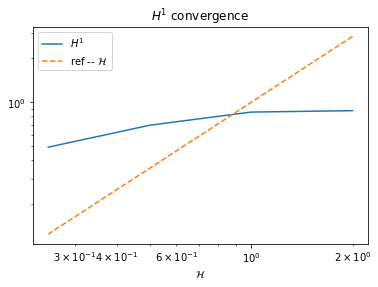

In [2]:
import matplotlib.pyplot as plt

# Load the data from the file into three arrays
m, eL2, eH1 = [], [], []
with open('conv_data_mhm_oscillatory_m.txt', 'r') as file:
    for line in file:
        values = line.split()
        m.append(1.0/(pow(2,float(values[0])-1)))
        eL2.append(float(values[1]))
        eH1.append(float(values[2]))

l = 0
rH1 = [pow(i, l+1.5) for i in m]
        
plt.plot(H, eH1, label=r'$H^1$')
plt.plot(H, rH1, label=r'ref -- $\mathcal{H}$', linestyle="dashed")
plt.xlabel(r'$\mathcal{H}$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$H^1$ convergence')
plt.legend()
plt.show()